# Recomendacion Tarjeta de Crédito

Para el proyecto, hemos decidido que el **target** del modelo sea la variable `sale_credit_card`, que refleja si un cliente ha contratado una tarjeta de crédito en algún momento. Este enfoque nos permite capturar de manera más eficiente el historial de productos financieros contratados por los clientes, lo que es esencial para maximizar el potencial predictivo del modelo y optimizar el uso de los recursos de marketing. Además, realizaremos predicciones sobre aquellos clientes que aún no han contratado una tarjeta de crédito, con el objetivo de identificar quiénes tienen mayor probabilidad de hacerlo en el futuro. A continuación, se detallan las razones que justifican esta decisión:

### 1. Producto de tarjeta de crédito
Nos hemos enfocado en la tarjeta de crédito como producto objetivo de la campaña, ya que, entre los productos de financiación, es el que tiene mayor representación en nuestra base de clientes. Además, según la información proporcionada, la rentabilidad por cada tarjeta contratada es de **60€**, superando a otros productos financieros como las cuentas (10€) y los productos de ahorro e inversión (40€). Este enfoque no solo nos permite aprovechar el producto con más éxito entre nuestros clientes, sino también maximizar el beneficio económico de la campaña.

### 2. Captura del comportamiento histórico del cliente
La creación de una variable de "sale" para cada producto, incluida la tarjeta de crédito, permite consolidar el historial de contratación de productos financieros de cada cliente. Aunque no se utilizan múltiples instancias de un mismo cliente en distintas fechas de ingesta de datos, estas variables encapsulan si el cliente ha tenido un producto en el pasado. Esto es clave, ya que el historial de contratación de productos es un fuerte predictor de futuras decisiones de compra, especialmente en el ámbito financiero.

### 3. Optimización de recursos de marketing
Al predecir qué clientes sin tarjeta de crédito tienen mayor probabilidad de contratar una, podemos enfocar los esfuerzos de marketing en estos clientes, en lugar de realizar campañas indiscriminadas. Esto mejora la eficiencia, reduce costos y maximiza el retorno de inversión (ROI) al dirigirse a un público con mayor potencial de conversión. **Dado que esta fue una solicitud directa del equipo de marketing, este enfoque nos permitirá identificar a los 10,000 clientes con mayor probabilidad de contratar una tarjeta de crédito y enfocar la campaña de envío de emails específicamente en ellos**.

### 4. Mejor representación de clientes con tarjeta
Al utilizar la variable `sale_credit_card` como objetivo, garantizamos que haya una mayor representación de clientes que han tenido una tarjeta de crédito, lo que ayuda a que el modelo sea más robusto y generalice mejor. Esto es importante en un contexto donde los clientes sin tarjeta suelen ser la mayoría, ya que el modelo podría sesgarse hacia ellos si no se equilibran correctamente las clases.

### 5. Reducción de duplicidad y ruido
Consolidar el comportamiento histórico en una única variable por producto evita la redundancia que podría surgir al incluir múltiples filas del mismo cliente en diferentes fechas de ingesta. Esto reduce el ruido en los datos y mejora la precisión del modelo, permitiendo que se enfoque en patrones de comportamiento más claros.

---

En resumen, el enfoque predictivo sobre los clientes que no tienen tarjeta de crédito, utilizando como target la variable `sale_credit_card`, nos permitirá capturar el comportamiento histórico de los clientes y optimizar la campaña de marketing al encontrar a los 10,000 clientes con más probabilidades de contratar una tarjeta de crédito. Esto no solo responde a los objetivos de rentabilidad establecidos por el equipo de marketing, sino que también asegura que la campaña esté enfocada en los clientes con mayor potencial de conversión.


# Generar el modelo

## 1. Importar librerias

In [1]:
import numpy as np 
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,roc_curve,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

## 2. Leer datos de AWS

In [2]:
df_full = pd.read_parquet("https://easy-money-project-bucket.s3.eu-west-3.amazonaws.com/df_full_cleaned.parquet")
df_full

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años


## 3. Función para el cálculo de ventas históricas

In [3]:
def calculate_historical_sales(df, product_columns):
    # Crear un DataFrame temporal con solo las columnas de productos
    df_products = df[product_columns]
    
    # Calcular la suma de cada producto por cliente
    product_sums = df_products.groupby(df['pk_cid']).sum()
    
    # Convertir las sumas a 1 (si > 0) o 0
    product_sales = (product_sums > 0).astype(int)
    
    # Renombrar las columnas
    product_sales.columns = [f'sale_{col}' for col in product_sales.columns]
    
    # Fusionar los resultados con el DataFrame original
    return df.merge(product_sales, left_on='pk_cid', right_index=True, how='left')

# Lista de productos
product_columns = [
    'credit_card', 'short_term_deposit', 'loans', 'mortgage', 'funds',
    'securities', 'long_term_deposit', 'em_account_pp', 'payroll',
    'pension_plan', 'payroll_account', 'emc_account', 'debit_card',
    'em_account_p', 'em_acount'  # Nota: corregí 'em_acount' que estaba mal escrito en el original
]

# Aplicar la función
df_full = calculate_historical_sales(df_full, product_columns)

In [4]:
df_full.head()

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
0,1375586,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,1,January,Adultos jóvenes,"87,218.100",Málaga,2018-01-12,Otros,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1,1050611,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"35,548.740",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"122,179.110",Ciudad Real,2015-08-10,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,40,0,ES,H,1,January,Jóvenes,"119,775.540",Zaragoza,2015-08-10,KHD,0,03 - UNIVERSITARIO,Más de 3 años,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"101,469.135",Zaragoza,2015-08-10,KHE,1,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
# Comprobar en un cliente la funcion
df_full[df_full['pk_cid'] == 1167274]

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
161673,1167274,2018-01-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,1,January,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
313183,1167274,2018-02-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,2,February,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
531223,1167274,2018-03-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,3,March,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
775879,1167274,2018-04-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,4,April,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1173970,1167274,2018-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1427338,1167274,2018-06-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,6,June,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
1536602,1167274,2018-07-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,7,July,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2158307,1167274,2018-08-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,8,August,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2392691,1167274,2018-09-28,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,20,0,0,ES,V,9,September,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2647752,1167274,2018-10-28,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2,1,2,0,0,0,0,20,0,0,ES,V,10,October,Jóvenes,"61,016.580",Salamanca,2016-08-19,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 54 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   pk_cid                   int64         
 1   pk_partition             datetime64[ns]
 2   short_term_deposit       int8          
 3   loans                    int8          
 4   mortgage                 int8          
 5   funds                    int8          
 6   securities               int8          
 7   long_term_deposit        int8          
 8   em_account_pp            int8          
 9   credit_card              int8          
 10  payroll                  int8          
 11  pension_plan             int8          
 12  payroll_account          int8          
 13  emc_account              int8          
 14  debit_card               int8          
 15  em_account_p             int8          
 16  em_acount                int8          
 17  num_products_contracts   in

## 4. Filtrar ultima particion

In [11]:
# Filtramos por la ultima particion
df_ultima_particion = df_full[df_full["pk_partition"] == "2019-05-28"]

In [8]:
# Filtramos el dataframe por la ultima visualizacion de cada cliente 
df = df_full.drop_duplicates(subset='pk_cid', keep='last').reset_index(drop=True)


In [9]:
df['credit_card'].value_counts()

credit_card
0    451571
1      4802
Name: count, dtype: int64

In [12]:
df_ultima_particion['credit_card'].value_counts()

credit_card
0    438194
1      4801
Name: count, dtype: int64

In [10]:
df['sale_credit_card'].value_counts()

sale_credit_card
0    447842
1      8531
Name: count, dtype: int64

In [13]:
df_ultima_particion['sale_credit_card'].value_counts()

sale_credit_card
0    434562
1      8433
Name: count, dtype: int64

## 5. Comprobar nulos y duplicados

In [14]:
df.isna().sum().sum()

0

In [15]:
df.duplicated().sum()

0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456373 entries, 0 to 456372
Data columns (total 54 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   pk_cid                   456373 non-null  int64         
 1   pk_partition             456373 non-null  datetime64[ns]
 2   short_term_deposit       456373 non-null  int8          
 3   loans                    456373 non-null  int8          
 4   mortgage                 456373 non-null  int8          
 5   funds                    456373 non-null  int8          
 6   securities               456373 non-null  int8          
 7   long_term_deposit        456373 non-null  int8          
 8   em_account_pp            456373 non-null  int8          
 9   credit_card              456373 non-null  int8          
 10  payroll                  456373 non-null  int8          
 11  pension_plan             456373 non-null  int8          
 12  payroll_account 

## 6. Eliminar columnas

In [17]:
df.drop('entry_date', axis=1, inplace=True)
df.drop('em_account_pp', axis=1, inplace=True)
df.drop('sale_em_account_pp', axis=1, inplace=True)
df.drop('credit_card', axis=1, inplace=True)
df.drop('country_id', axis=1, inplace=True)
df.drop('pk_partition', axis=1, inplace=True)
df.set_index('pk_cid', inplace=True)

In [18]:
df['entry_channel'].value_counts()

entry_channel
KHE      196594
KHQ       76168
KFC       60183
KHM       32262
KAT       27016
KHK       17070
KHN       16983
Otros     15769
KFA        5129
KHD        4860
RED        4339
Name: count, dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456373 entries, 635756 to 1550586
Data columns (total 47 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   short_term_deposit       456373 non-null  int8    
 1   loans                    456373 non-null  int8    
 2   mortgage                 456373 non-null  int8    
 3   funds                    456373 non-null  int8    
 4   securities               456373 non-null  int8    
 5   long_term_deposit        456373 non-null  int8    
 6   payroll                  456373 non-null  int8    
 7   pension_plan             456373 non-null  int8    
 8   payroll_account          456373 non-null  int8    
 9   emc_account              456373 non-null  int8    
 10  debit_card               456373 non-null  int8    
 11  em_account_p             456373 non-null  int8    
 12  em_acount                456373 non-null  int8    
 13  num_products_contracts   456373 non-null  i

## 7. Correlación de variables numéricas

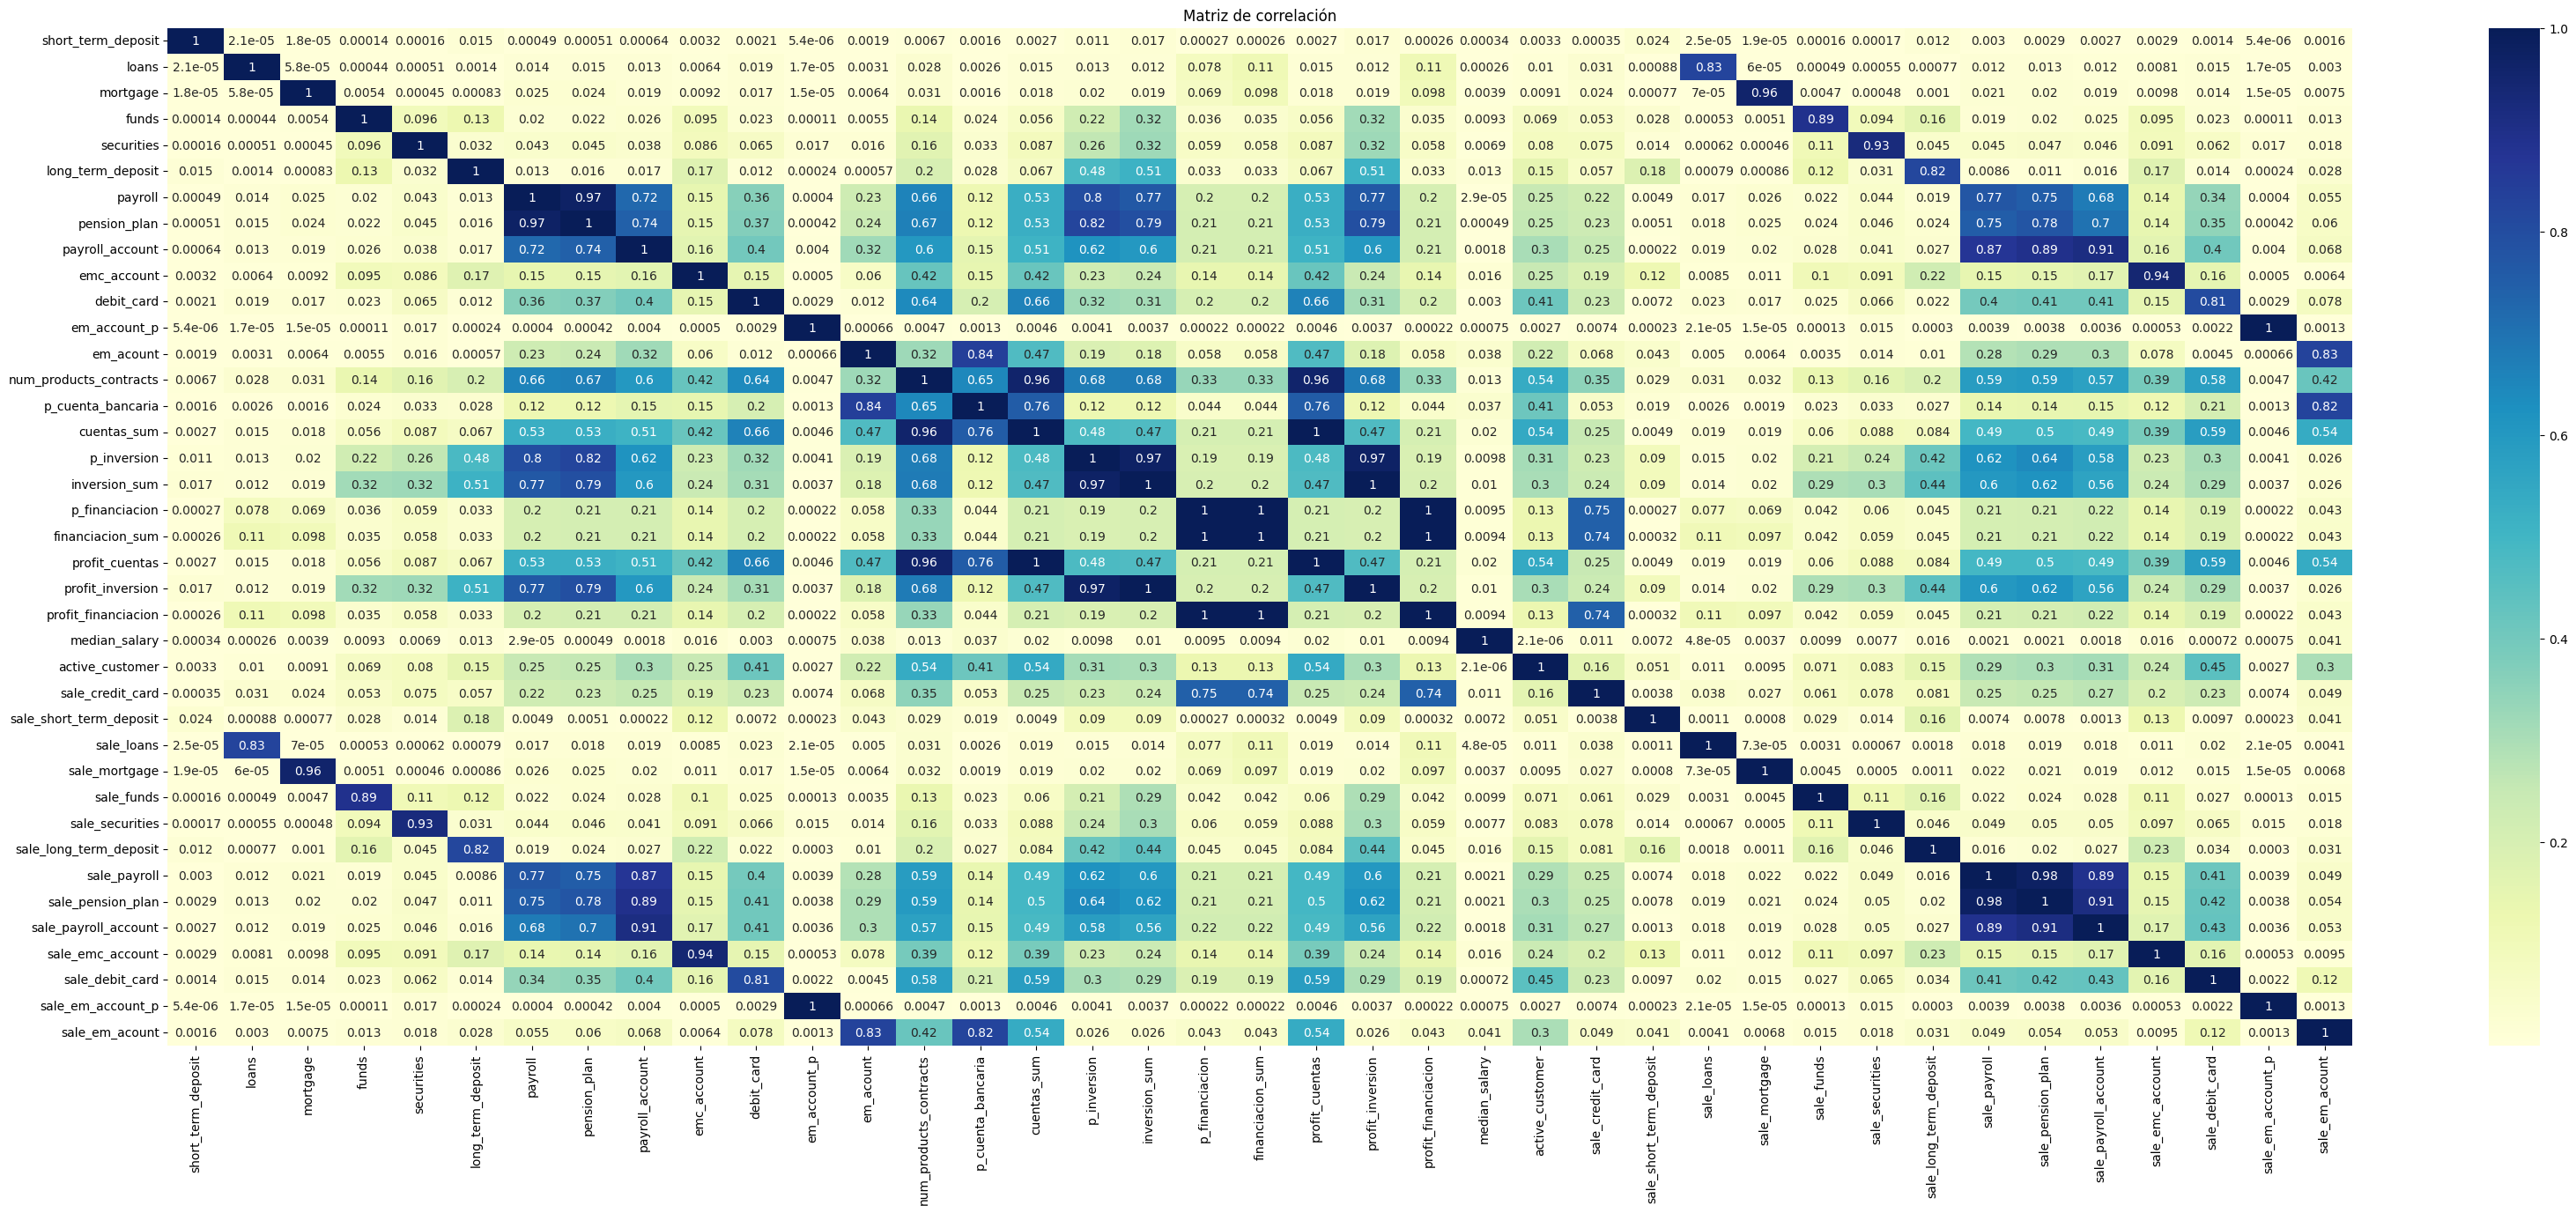

Columnas que no pasan al siguiente análisis debido a alta correlación: ['pension_plan', 'cuentas_sum', 'inversion_sum', 'financiacion_sum', 'profit_cuentas', 'profit_inversion', 'profit_financiacion', 'sale_mortgage', 'sale_securities', 'sale_pension_plan', 'sale_payroll_account', 'sale_emc_account', 'sale_em_account_p']


In [20]:
numerical_cols = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'long_term_deposit',  'payroll', 'pension_plan','payroll_account', 'emc_account', 'debit_card', 'em_account_p',
       'em_acount', 'num_products_contracts', 'p_cuenta_bancaria','cuentas_sum', 'p_inversion', 'inversion_sum', 'p_financiacion',
       'financiacion_sum', 'profit_cuentas', 'profit_inversion','profit_financiacion','median_salary','active_customer',
       'sale_credit_card', 'sale_short_term_deposit', 'sale_loans','sale_mortgage', 'sale_funds', 'sale_securities',
       'sale_long_term_deposit', 'sale_payroll','sale_pension_plan', 'sale_payroll_account', 'sale_emc_account',
       'sale_debit_card', 'sale_em_account_p', 'sale_em_acount']

# Calcular la matriz de correlación para las columnas numéricas
correlation_matrix = df[numerical_cols].corr().abs()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(40, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu')
plt.title("Matriz de correlación")
plt.show()

# Identificar columnas con correlación mayor a 0.90
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Encuentra las columnas que tienen correlación > 0.90
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]

# Eliminar columnas con alta correlación en el conjunto de entrenamiento
df = df.drop(columns=to_drop)

# Mostrar columnas eliminadas
print("Columnas que no pasan al siguiente análisis debido a alta correlación:", to_drop)

## 8. Separación de X e y

In [21]:
# Preparar las características (X) y la variable objetivo (y)
X = df.drop(columns=['sale_credit_card'])
y = df['sale_credit_card']


In [22]:
X

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,payroll,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,p_inversion,p_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_short_term_deposit,sale_loans,sale_funds,sale_long_term_deposit,sale_payroll,sale_debit_card,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
635756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,7,July,Adultos,"118,183.410",Madrid,KAT,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,1
606127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,7,July,Longevos,"152,041.110",Madrid,KFA,0,03 - UNIVERSITARIO,1-2 años,0,0,0,1,0,0,0
611844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,7,July,Adultos jóvenes,"87,351.090",Málaga,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0
543177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,7,July,Adultos,"179,142.540",Madrid,Otros,0,03 - UNIVERSITARIO,1-2 años,0,0,0,0,0,0,0
528596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,7,July,Adultos jóvenes,"125,161.530",Madrid,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166765,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,V,5,May,Jóvenes,"43,912.170",Zaragoza,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,1
1166764,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,V,5,May,Jóvenes,"23,334.990","Rioja, La",KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,1,1
1166763,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,H,5,May,Adultos,"87,930.930",Zaragoza,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,1


In [23]:
y.value_counts()

sale_credit_card
0    447842
1      8531
Name: count, dtype: int64

## 9. Undersampling

In [24]:

# Crear un modelo de undersampling
undersampler = RandomUnderSampler(sampling_strategy=0.6,random_state=42)  # Establece un random seed para reproducibilidad
X_resampled, y_resampled = undersampler.fit_resample(X, y)


In [47]:
X_resampled

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,payroll,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,p_inversion,p_financiacion,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_channel,active_customer,segment,categoria_antiguedad,sale_short_term_deposit,sale_loans,sale_funds,sale_long_term_deposit,sale_payroll,sale_debit_card,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1191133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,H,5,May,Adultos jóvenes,"87,310.230",Navarra,KHE,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,1
1155797,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,H,5,May,Adultos jóvenes,"81,243.270",Zamora,KAT,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,1
1454737,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,V,5,May,Adultos jóvenes,"62,658.090",Valencia,KHM,0,02 - PARTICULARES,6-9 meses,0,0,0,0,0,0,1
1225366,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,V,5,May,Jóvenes,"87,507.930",Murcia,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,1
1061976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,V,5,May,Adultos jóvenes,"66,212.190",Murcia,KHE,0,03 - UNIVERSITARIO,Más de 3 años,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1167029,0,0,0,0,0,0,0,0,1,0,0,1,2,1,0,0,V,5,May,Adultos,"81,258.390",Madrid,KFC,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,1
1167114,0,0,0,0,0,0,1,1,1,1,0,0,6,1,1,1,V,5,May,Adultos,"65,335.140",Alicante,KAT,1,02 - PARTICULARES,2-3 años,0,0,0,0,1,1,0
1167055,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,V,5,May,Adultos jóvenes,"128,593.050",Asturias,KFC,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0


In [25]:
y_resampled.value_counts()

sale_credit_card
0    14218
1     8531
Name: count, dtype: int64

## 10. One-Hot Encoding de variables categóricas


In [26]:
# One-Hot Encoding para las variables categóricas
categorical_cols = X_resampled.select_dtypes(include=['object', 'category']).columns
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_ohe = pd.DataFrame(ohe.fit_transform(X_resampled[categorical_cols]), 
                    columns=ohe.get_feature_names_out(categorical_cols), index=X_resampled.index)


## 11. Escalado con RobustScaler de variables numéricas


In [27]:
# RobustScaler para las variables numéricas
numerical_cols = X_resampled.select_dtypes(include=['int64', 'float64','int32','int8']).columns
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_resampled[numerical_cols]), 
                        columns=numerical_cols, index=X_resampled.index)


In [28]:
# Combinar las columnas procesadas
X_processed = pd.concat([X_scaled, X_ohe], axis=1)

In [29]:
X_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,payroll,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,p_inversion,p_financiacion,mes_partition,median_salary,active_customer,sale_short_term_deposit,sale_loans,sale_funds,sale_long_term_deposit,sale_payroll,sale_debit_card,sale_em_acount,gender_V,mes_nombre_partition_August,mes_nombre_partition_December,mes_nombre_partition_February,mes_nombre_partition_January,mes_nombre_partition_July,mes_nombre_partition_March,mes_nombre_partition_May,mes_nombre_partition_November,mes_nombre_partition_October,mes_nombre_partition_September,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,region_code_Asturias,region_code_Badajoz,"region_code_Baleares, Islas",region_code_Barcelona,region_code_Bizkaia,...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1191133,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.500,-1.000,0.000,0.000,0.000,-0.067,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
1155797,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.165,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000
1454737,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.466,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
1225366,0.000,0.0

In [30]:
X_processed.index.nunique()

22749

## 12. Separación de Train y Test

In [31]:
# Separar el conjunto en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_resampled,test_size=0.2, random_state=42)


## 13. Entrenamiento y Optimización del Modelo XGBoost


In [32]:
# Crear el modelo de XGBoost
xgb_model = xgb.XGBClassifier()

In [33]:
# Definir el grid de hiperparámetros a optimizar
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5]
}

In [34]:
# Usar RandomizedSearchCV para buscar los mejores hiperparámetros
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=50, scoring='accuracy', 
                                n_jobs=-1, cv=3, verbose=2, random_state=42)

In [36]:
# Entrenar con los datos de entrenamiento
random_search.fit(X_train, y_train,verbose=1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=2)

In [37]:
# Ver los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", random_search.best_params_)

Mejores hiperparámetros: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 1.0}


In [38]:
# Predecir con el mejor modelo
xgb_model = random_search.best_estimator_

## 14. Evaluación del Modelo


In [39]:
# Hacer predicciones
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidades de clase positiva

In [40]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [41]:
# Imprimir métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.91
ROC AUC: 0.97

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      2855
           1       0.90      0.86      0.88      1695

    accuracy                           0.91      4550
   macro avg       0.91      0.90      0.91      4550
weighted avg       0.91      0.91      0.91      4550



Los resultados de la evaluación del modelo indican un rendimiento bastante sólido en la clasificación de clientes en las categorías definidas. Con un accuracy del 91%, podemos concluir que el modelo está acertando en la clasificación de la mayoría de los casos, lo cual es notable, especialmente en el contexto de predicción de la contratación de productos financieros.

El ROC AUC de 0.97 es un indicador excepcional de la capacidad del modelo para discriminar entre las clases. Un valor de 1.0 indica una clasificación perfecta, mientras que un valor de 0.5 sugiere que el modelo no está haciendo mejor que el azar. Con un AUC tan alto, se puede inferir que el modelo tiene una excelente capacidad para identificar correctamente tanto a los clientes que contratarán la tarjeta de crédito (clase 1) como a aquellos que no lo harán (clase 0).

La precisión (precision) para la clase 0 es de 0.92, lo que significa que el modelo es muy confiable al predecir clientes que no contratarán la tarjeta de crédito. Sin embargo, la precisión para la clase 1 es de 0.90, lo que sugiere que aunque el modelo identifica correctamente a muchos clientes que sí contratarán la tarjeta.

El recall para la clase 1 es de 0.86, lo que indica que el modelo está capturando el 86% de los clientes que realmente contratan la tarjeta. Aunque esto es bueno, todavía hay un 14% de clientes que el modelo no logra identificar.

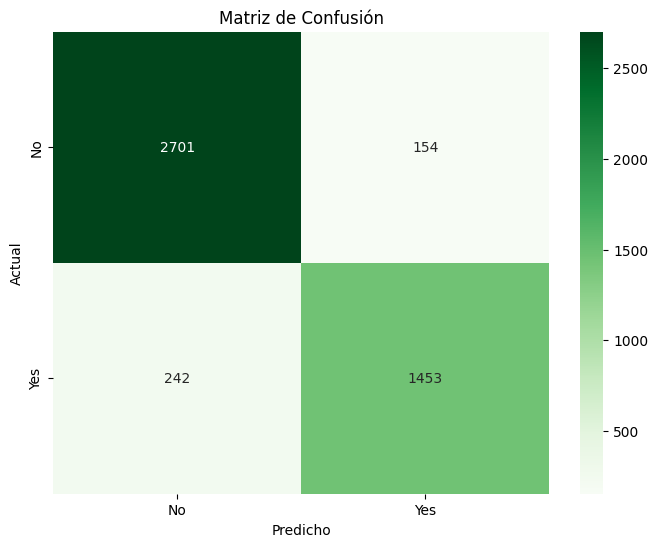

In [43]:
# Gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión')
plt.show()

Esta matriz muestra que el modelo ha clasificado correctamente 2701 clientes que no contratarán la tarjeta de crédito y 1453 clientes que sí la contratarán. Sin embargo, hay 154 falsos positivos (clientes que no contratarán la tarjeta, pero que fueron clasificados como que sí lo harán) y 242 falsos negativos (clientes que sí contratarán la tarjeta, pero que fueron clasificados como que no lo harán).

Considerando que contamos con un conjunto de datos relativamente pequeño, creemos que el modelo es bastante válido para el propósito de identificar a los clientes que podrían estar interesados en contratar una tarjeta de crédito. Aunque hay margen para mejorar, los resultados son lo suficientemente sólidos como para permitirnos buscar la probabilidad de compra de la tarjeta de crédito entre los clientes que no la tienen contratada.

En resumen, el modelo ha demostrado ser efectivo en la clasificación y ofrece una base sólida para enfocar las campañas de marketing hacia los clientes con mayor probabilidad de contratar el producto.

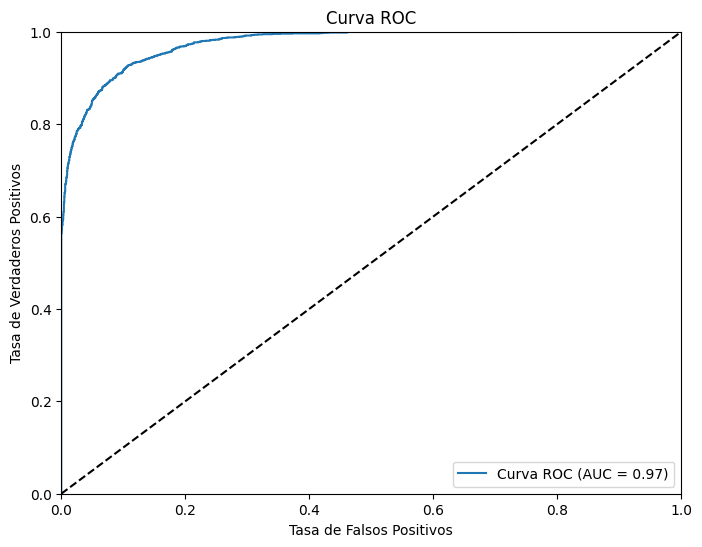

In [44]:
# Gráfico de la curva ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

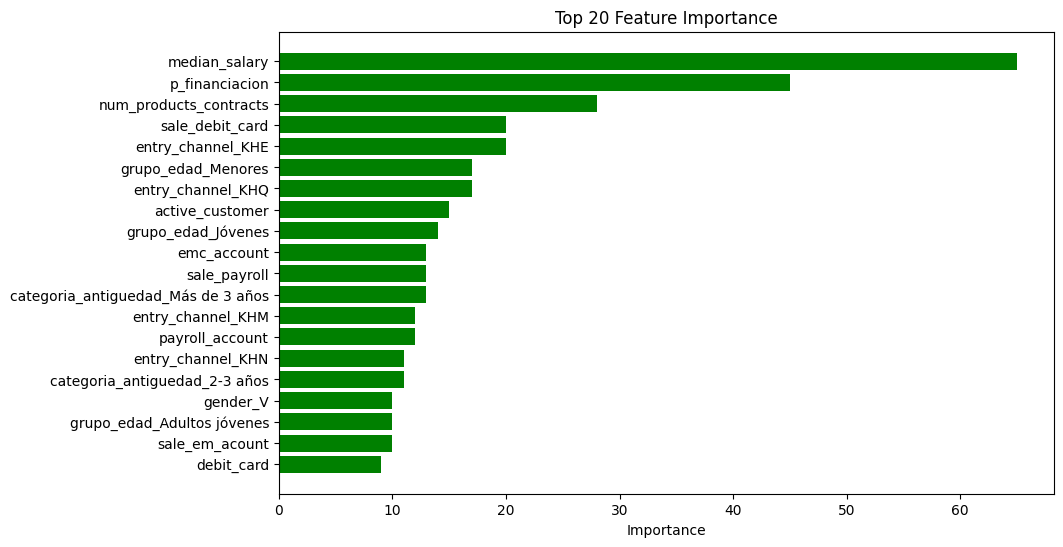

In [45]:
# Obtener la importancia de las características
importance = xgb_model.get_booster().get_score(importance_type='weight')

# Convertir a un DataFrame para mejor visualización
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Seleccionar solo las 20 características más importantes
top_20_importance_df = importance_df.head(20)

# Graficar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(top_20_importance_df['Feature'], top_20_importance_df['Importance'], color='green')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la más importante en la parte superior
plt.show()

## 15. Importancia de las Características

En nuestro modelo de predicción, hemos identificado varias características que juegan un papel crucial en la determinación de la probabilidad de que un cliente contrate una tarjeta de crédito. A continuación, se presentan las características más importantes, junto con una breve justificación de su relevancia:

1. **Salario (`median_salary`)**:
   - **Importancia**: Esta es la característica más significativa, con una diferencia considerable respecto a las demás.
   - **Justificación**: El salario es un indicador clave de la capacidad financiera de un cliente. Aquellos con un salario más alto suelen tener una mayor capacidad para manejar pagos y deudas, lo que los hace más propensos a contratar productos de crédito. Este factor es fundamental para las entidades financieras, ya que ayuda a evaluar el riesgo de impago.

2. **Productos de Financiación Contratados (`p_financiacion`)**:
   - **Importancia**: Esta característica representa la cantidad de productos de financiación que el cliente tiene contratados.
   - **Justificación**: Los clientes que ya han contratado productos de financiación, como préstamos o hipotecas, pueden ser más propensos a contratar una tarjeta de crédito. Esto se debe a que su historial de crédito y su experiencia con la gestión de deuda son factores que influyen en su decisión de solicitar productos de crédito adicionales.

3. **Número de Productos Contratados (`num_products_contracts`)**:
   - **Importancia**: El total de productos que un cliente ha contratado con la entidad.
   - **Justificación**: Un mayor número de productos contratados indica un compromiso más fuerte con la entidad financiera, lo que puede resultar en una mayor disposición a adquirir nuevos productos. Los clientes que tienen múltiples productos con el banco tienden a confiar más en la institución, lo que aumenta la probabilidad de que consideren productos adicionales, como una tarjeta de crédito.

4. **Venta de Tarjeta de Débito (`sale_debit_card`)**:
   - **Importancia**: La cuarta característica más relevante es si el cliente ha tenido alguna vez una tarjeta de débito.
   - **Justificación**: La posesión de una tarjeta de débito puede indicar una relación previa con la entidad financiera y un comportamiento financiero responsable. Además, los clientes que utilizan productos de débito pueden estar más abiertos a considerar productos de crédito, ya que ya están familiarizados con la gestión de cuentas bancarias.








# Predicciones


Para asegurar que nuestras predicciones sean precisas y reflejen el comportamiento más reciente de los clientes, hemos decidido filtrar el DataFrame utilizando únicamente la última ingesta de datos.

In [46]:
df_ultima_particion

,pk_cid,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
5519929,657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5519930,657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5519931,657986,2019-05-28,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,6,1,4,1,1,1,1,40,40,60,ES,H,5,May,Adultos jóvenes,"100,993.170",Sevilla,2016-02-18,Otros,1,02 - PARTICULARES,Más de 3 años,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0
5519932,657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
5519933,657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962920,1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5962921,1166763,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"87,930.930",Zaragoza,2016-08-14,KHE,1,02 - PARTICULARES,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5962922,1166789,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"199,592.820",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [48]:
df_ultima_particion.set_index('pk_cid', inplace=True)

In [51]:
# Filtrar df_ultima_ingesta para eliminar los clientes que ya están en X_resampled
df__ultima_particion_filtrado = df_ultima_particion[~df_ultima_particion.index.isin(X_resampled.index)]

In [52]:
df__ultima_particion_filtrado

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657147,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"104,881.710",Madrid,2017-06-09,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166766,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"50,945.250",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [53]:
# Seleccionamos los clientes que no se han usado para el entrenamiento que no han contratado la tajeta de credito 

df_customers_no_credit_card = df__ultima_particion_filtrado[df__ultima_particion_filtrado['sale_credit_card'] == 0]


In [54]:
df_customers_no_credit_card['sale_credit_card'].value_counts()

sale_credit_card
0    420752
Name: count, dtype: int64

In [55]:
df_customers_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657147,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"104,881.710",Madrid,2017-06-09,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166766,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"50,945.250",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [56]:
# Obtener las características (X) de los clientes sin tarjeta de crédito
X_no_credit_card = df_customers_no_credit_card.drop(columns=['sale_credit_card'])

In [57]:
X_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,1,0,0,0,0,0,0,0,1
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,1
657147,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"104,881.710",Madrid,2017-06-09,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166766,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"50,945.250",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [58]:
# Eliminar columnas que no se incluyeron en el modelo de entrenamiento y las que tenian alta correlacion.

X_no_credit_card.drop('entry_date', axis=1, inplace=True)
X_no_credit_card.drop('em_account_pp', axis=1, inplace=True)
X_no_credit_card.drop('sale_em_account_pp', axis=1, inplace=True)
X_no_credit_card.drop('credit_card', axis=1, inplace=True)
X_no_credit_card.drop('country_id', axis=1, inplace=True)
X_no_credit_card.drop('pension_plan', axis=1, inplace=True)
X_no_credit_card.drop('cuentas_sum', axis=1, inplace=True)
X_no_credit_card.drop('inversion_sum', axis=1, inplace=True)
X_no_credit_card.drop('financiacion_sum', axis=1, inplace=True)
X_no_credit_card.drop('profit_cuentas', axis=1, inplace=True)
X_no_credit_card.drop('profit_inversion', axis=1, inplace=True)
X_no_credit_card.drop('profit_financiacion', axis=1, inplace=True)
X_no_credit_card.drop('sale_mortgage', axis=1, inplace=True)
X_no_credit_card.drop('sale_securities', axis=1, inplace=True)
X_no_credit_card.drop('sale_pension_plan', axis=1, inplace=True)
X_no_credit_card.drop('sale_payroll_account', axis=1, inplace=True)
X_no_credit_card.drop('sale_emc_account', axis=1, inplace=True)
X_no_credit_card.drop('sale_em_account_p', axis=1, inplace=True)


In [59]:
# One-Hot Encoding para las variables categóricas
X_no_credit_card_ohe = pd.DataFrame(ohe.transform(X_no_credit_card[categorical_cols]), 
                                columns=ohe.get_feature_names_out(categorical_cols), 
                                index=X_no_credit_card.index)

In [60]:
# Escalar las variables numéricas
X_no_credit_card_scaled = pd.DataFrame(scaler.transform(X_no_credit_card[numerical_cols]), 
                                       columns=numerical_cols, 
                                       index=X_no_credit_card.index)

In [61]:
# Combinar las columnas procesadas
X_no_credit_card_processed = pd.concat([X_no_credit_card_scaled, X_no_credit_card_ohe], axis=1)

In [62]:
X_no_credit_card_processed

,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,payroll,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,p_inversion,p_financiacion,mes_partition,median_salary,active_customer,sale_short_term_deposit,sale_loans,sale_funds,sale_long_term_deposit,sale_payroll,sale_debit_card,sale_em_acount,gender_V,mes_nombre_partition_August,mes_nombre_partition_December,mes_nombre_partition_February,mes_nombre_partition_January,mes_nombre_partition_July,mes_nombre_partition_March,mes_nombre_partition_May,mes_nombre_partition_November,mes_nombre_partition_October,mes_nombre_partition_September,grupo_edad_Adultos jóvenes,grupo_edad_Adultos mayores,grupo_edad_Ancianos,grupo_edad_Jóvenes,grupo_edad_Longevos,grupo_edad_Menores,region_code_Alicante,region_code_Almería,region_code_Asturias,region_code_Badajoz,"region_code_Baleares, Islas",region_code_Barcelona,region_code_Bizkaia,...,region_code_Granada,region_code_Guadalajara,region_code_Huelva,region_code_Huesca,region_code_Jaén,region_code_León,region_code_Lleida,region_code_Lugo,region_code_Madrid,region_code_Melilla,region_code_Murcia,region_code_Málaga,region_code_Navarra,region_code_Ourense,region_code_Palencia,"region_code_Palmas, Las",region_code_Pontevedra,"region_code_Rioja, La",region_code_Salamanca,region_code_Santa Cruz de Tenerife,region_code_Segovia,region_code_Sevilla,region_code_Soria,region_code_Tarragona,region_code_Teruel,region_code_Toledo,region_code_Valencia,region_code_Valladolid,region_code_Zamora,region_code_Zaragoza,region_code_Álava,region_code_Ávila,entry_channel_KFA,entry_channel_KFC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHK,entry_channel_KHM,entry_channel_KHN,entry_channel_KHQ,entry_channel_Otros,entry_channel_RED,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,categoria_antiguedad_1-2 años,categoria_antiguedad_2-3 años,categoria_antiguedad_3-6 meses,categoria_antiguedad_6-9 meses,categoria_antiguedad_9-12 meses,categoria_antiguedad_Más de 3 años
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.599,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
657817,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,-0.500,-1.000,0.000,0.000,0.000,0.465,-1.000,0.000,0.000,0.000,0.000,0.000,0.000,-1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
657905,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,0.000,1.000,0.000,0.000,1.014,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000
657336,0.000,0.000,0.0

In [63]:
# Predecir las probabilidades para los clientes sin tarjeta de crédito
probabilities_no_credit_card = xgb_model.predict_proba(X_no_credit_card_processed)[:, 1]

In [64]:
# Agregar las probabilidades al DataFrame original
df_customers_no_credit_card['probability'] = probabilities_no_credit_card

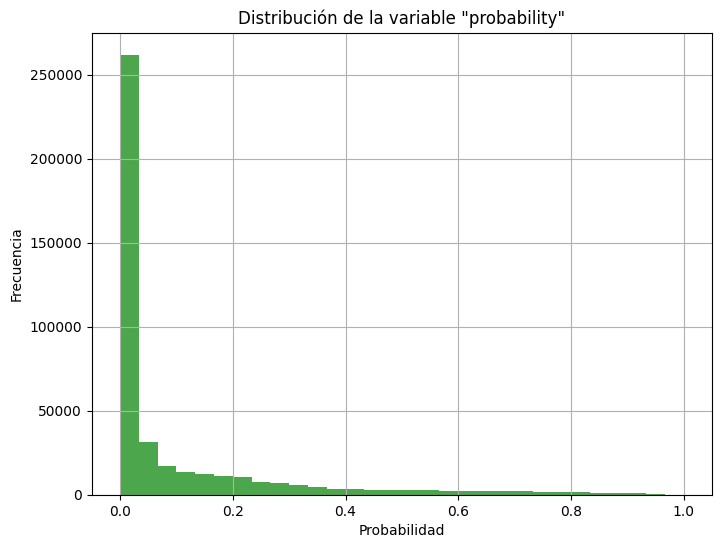

In [65]:
# Graficamos la distribución
plt.figure(figsize=(8,6))
plt.hist(data= df_customers_no_credit_card, x='probability', bins=30, color='green', alpha=0.7)
plt.title('Distribución de la variable "probability"')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Como podemos observar en la gráfica de la distribución de la variable "probability", la mayoría de los clientes que no tienen la tarjeta de crédito contratada presentan una probabilidad baja de adquirirla, con muchas de estas probabilidades cercanas a 0. Este comportamiento es esperado, ya que una parte significativa de nuestra base de clientes probablemente no está interesada en contratar este producto o no presenta las características necesarias para que el modelo prediga una alta probabilidad de conversión.

Sin embargo, el objetivo de nuestra campaña de marketing no es abarcar a todos los clientes, sino identificar a aquellos que tienen la mayor probabilidad de adquirir la tarjeta de crédito. Para ello, nos hemos centrado en seleccionar los 10,000 clientes con las probabilidades más altas, ya que estos representan la mejor oportunidad para maximizar la efectividad de la campaña de email. Evaluar a estos clientes con mayor detalle nos permitirá enfocar los recursos en un grupo reducido, pero más propenso a la conversión.

In [66]:
df_customers_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
657826,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Adultos,"54,493.380",Lleida,2015-05-24,Otros,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.253
657817,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,V,5,May,Adultos jóvenes,"120,141.600",Barcelona,2019-05-12,Otros,0,03 - UNIVERSITARIO,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.038
657905,2019-05-28,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,1,1,1,1,0,0,10,40,0,ES,H,5,May,Longevos,"154,059.090",Madrid,2017-02-07,KAT,1,01 - TOP,2-3 años,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.476
657336,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"108,223.410",Madrid,2019-03-28,KAT,1,02 - PARTICULARES,0-3 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.200
657147,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,H,5,May,Adultos mayores,"104,881.710",Madrid,2017-06-09,KAT,0,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166766,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Adultos jóvenes,"50,945.250",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.006
1166765,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"43,912.170",Zaragoza,2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.003
1166764,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"23,334.990","Rioja, La",2016-08-14,KHE,0,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0.035


In [67]:
df_sorted = df_customers_no_credit_card.sort_values(by='probability', ascending=False)

In [68]:
df_sorted

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1200307,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,V,5,May,Adultos mayores,"937,306.320",Madrid,2016-10-15,KFC,1,02 - PARTICULARES,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
330599,2019-05-28,0,0,1,1,0,0,0,0,1,1,1,1,1,0,0,7,1,4,1,2,1,1,40,80,60,ES,H,5,May,Adultos mayores,"314,597.850",Madrid,2016-11-21,KFA,1,02 - PARTICULARES,2-3 años,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,1.000
1136531,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,H,5,May,Adultos jóvenes,"236,739.840",Madrid,2016-06-06,KAT,1,02 - PARTICULARES,Más de 3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
1138692,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,V,5,May,Adultos,"265,487.490",Madrid,2016-06-27,KFC,1,02 - PARTICULARES,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
1258071,2019-05-28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,60,ES,V,5,May,Adultos,"714,033.300",Madrid,2017-09-17,KFA,1,02 - PARTICULARES,1-2 años,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490266,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"76,066.695",Teruel,2018-10-26,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000
1448344,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,H,5,May,Jóvenes,"70,177.050",Palencia,2018-09-14,KHQ,0,03 - UNIVERSITARIO,6-9 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000
1515264,2019-05-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,10,0,0,ES,V,5,May,Jóvenes,"71,492.235",León,2018-12-11,KHQ,0,03 - UNIVERSITARIO,3-6 meses,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000


In [69]:
# Seleccionar los 10,000 clientes sin tarjeta de crédito con mayor probabilidad de compra
top_customers_no_credit_card = df_customers_no_credit_card.nlargest(10000, 'probability')

In [70]:
top_customers_no_credit_card

,pk_partition,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,num_products_contracts,p_cuenta_bancaria,cuentas_sum,p_inversion,inversion_sum,p_financiacion,financiacion_sum,profit_cuentas,profit_inversion,profit_financiacion,country_id,gender,mes_partition,mes_nombre_partition,grupo_edad,median_salary,region_code,entry_date,entry_channel,active_customer,segment,categoria_antiguedad,sale_credit_card,sale_short_term_deposit,sale_loans,sale_mortgage,sale_funds,sale_securities,sale_long_term_deposit,sale_em_account_pp,sale_payroll,sale_pension_plan,sale_payroll_account,sale_emc_account,sale_debit_card,sale_em_account_p,sale_em_acount,probability
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1200307,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,V,5,May,Adultos mayores,"937,306.320",Madrid,2016-10-15,KFC,1,02 - PARTICULARES,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
330599,2019-05-28,0,0,1,1,0,0,0,0,1,1,1,1,1,0,0,7,1,4,1,2,1,1,40,80,60,ES,H,5,May,Adultos mayores,"314,597.850",Madrid,2016-11-21,KFA,1,02 - PARTICULARES,2-3 años,0,0,0,1,1,0,0,0,1,1,1,1,1,0,0,1.000
1136531,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,H,5,May,Adultos jóvenes,"236,739.840",Madrid,2016-06-06,KAT,1,02 - PARTICULARES,Más de 3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
1138692,2019-05-28,0,0,1,0,0,0,0,0,1,1,1,0,1,0,0,5,1,3,1,1,1,1,30,40,60,ES,V,5,May,Adultos,"265,487.490",Madrid,2016-06-27,KFC,1,02 - PARTICULARES,2-3 años,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0,1.000
1258071,2019-05-28,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,60,ES,V,5,May,Adultos,"714,033.300",Madrid,2017-09-17,KFA,1,02 - PARTICULARES,1-2 años,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108774,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,4,1,3,1,1,0,0,30,40,0,ES,H,5,May,Adultos jóvenes,"154,672.140",Sevilla,2015-12-03,KHE,1,02 - PARTICULARES,Más de 3 años,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0.701
1298291,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,6,1,5,1,1,0,0,50,40,0,ES,V,5,May,Adultos,"129,719.160",Cádiz,2017-08-22,KFC,1,02 - PARTICULARES,1-2 años,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,0.701
1209693,2019-05-28,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,4,1,3,1,1,0,0,30,40,0,ES,H,5,May,Adultos jóvenes,"66,520.140",Asturias,2016-10-28,KFC,1,03 - UNIVERSITARIO,2-3 años,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0.701


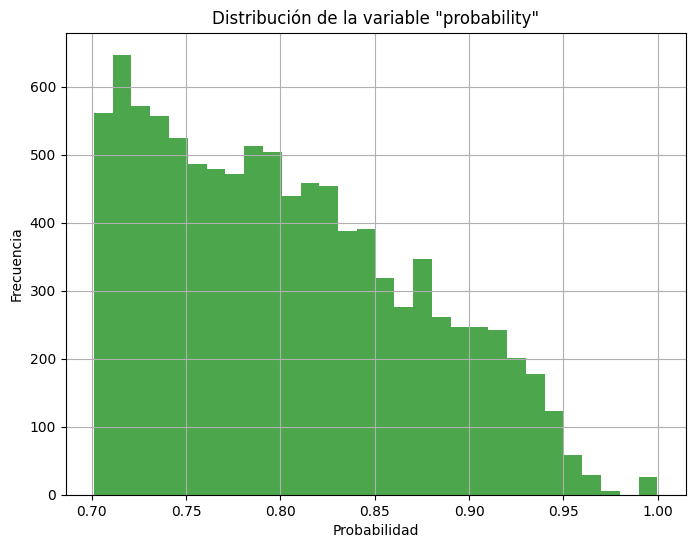

In [71]:
# Graficamos la distribución
plt.figure(figsize=(8,6))
plt.hist(data= top_customers_no_credit_card, x='probability', bins=30, color='green', alpha=0.7)
plt.title('Distribución de la variable "probability"')
plt.xlabel('Probabilidad')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [75]:
top_customers_no_credit_card['probability'].sum()

8029.626


La distribución de la variable "probability" muestra que la mayoría de los 10,000 clientes con mayor probabilidad de contratar la tarjeta de crédito se encuentran en un rango de probabilidad entre 0.7 y 0.85, con una tendencia descendente hacia probabilidades más altas. Esto sugiere que, aunque tenemos un número considerable de clientes con probabilidades moderadamente altas, hay menos clientes con probabilidades extremadamente altas (mayores a 0.95).

En la siguiente tarea, se procederá a realizar una clusterización de estos 10,000 clientes. Esto nos permitirá personalizar las creatividades de los correos electrónicos que se enviarán, ajustando el mensaje para diferentes grupos de clientes según su perfil y probabilidad de conversión.

In [73]:
top_customers_no_credit_card.to_parquet('top_customers_no_credit_card.parquet')


# ROI

Teniendo en cuenta que:

- Tasa de Respuesta: Proporción de clientes a quienes se les envía una campaña y que efectivamente responden (adquieren el producto recomendado).

- ROI (Retorno sobre la Inversión): Medida de la rentabilidad de una inversión. Se calcula como:
	
ROI = Beneficio Neto / Costo de la Inversión * 100

Donde:

Beneficio Neto = Ingresos Totales - Costo de la Inversión

ESTIMACIÓN DE LA TASA DE RESPUESTA

Dado que prob_compra ya representa la probabilidad individual de que cada cliente compre, la tasa de respuesta estimada se calcula sumando todas las probabilidades y dividiéndolo por el número total de clientes seleccionados.


Tasa de Respuesta Estimada =  SUM (prob_compra)/ Número de Clientes Seleccionados * 100


- La suma de prob_compra es 8,029.626, por tanto la tasa de respuesta estimada es de:

8,029.626 / 10,000 * 100 = 80.29%



Aunque parezca que la tasa de respuesta del 80% es muy alta, principalmente para el sector financiero, es este caso puede ser razonable:

- Selección óptima de clientes: Se ha seleccionado a los 10,000 clientes con mayor probabilidad de compra, según las predicciones del modelo. Estos clientes están en la cima del ranking en cuanto a probabilidad de compra, por lo que se podría esperar que una gran parte de ellos responda positivamente.
- Segmentación focalizada y personalizada: La campaña está personalizada y dirigida a los clientes correctos, con mensajes y productos que resuenen con ellos, la tasa de respuesta puede ser muy alta.


ESTIMACIÓN DEL ROI

In [78]:
# 1. Calcular el beneficio total esperado
beneficio_total_esperado = 60*0.8029*10000
print("El beneficio total esperado es de", round(beneficio_total_esperado), "€")


El beneficio total esperado es de 481740 €


In [80]:
# 2. Definir y calcular todos los costos de la campaña
# aqui se definen algunos costos de la campaña estimados
costo_por_correo = 0.50
costo_diseño = 15000
costo_plataforma = 10000
costo_incentivos = 20000

costo_total = (10000 * costo_por_correo) + costo_diseño + costo_plataforma + costo_incentivos

# 3. Definir una tasa de respuesta realista basada en datos históricos o benchmarks
tasa_respuesta_real = 0.5  

# 4. Calcular el beneficio esperado basado en la tasa de respuesta real
beneficio_respuestas_real = beneficio_total_esperado * tasa_respuesta_real

# 5. Calcular el beneficio neto
beneficio_neto_real = beneficio_respuestas_real - costo_total

# 6. Calcular el ROI realista
roi_real = (beneficio_neto_real / costo_total) * 100

# Mostrar los resultados
print(f"Beneficio Total Esperado: {beneficio_total_esperado:,.2f} €")
print(f"Beneficio Esperado de las Respuestas: {beneficio_respuestas_real:,.2f}€")
print(f"Costo Total de la Campaña: {costo_total:,.2f}€")
print(f"Beneficio Neto Real: {beneficio_neto_real:,.2f}€")
print(f"ROI: {roi_real:.2f}%")

Beneficio Total Esperado: 481,740.00 €
Beneficio Esperado de las Respuestas: 240,870.00€
Costo Total de la Campaña: 50,000.00€
Beneficio Neto Real: 190,870.00€
ROI: 381.74%


# Conclusión de ROI

Después de realizar un análisis exhaustivo de la campaña de marketing proyectada para 10,000 clientes con una probabilidad de compra del 80%, hemos obtenido resultados muy prometedores:

1. **Beneficio Total Esperado:** Se anticipa un beneficio total de **481,740.00 €**, lo que demuestra el alto potencial de retorno que esta campaña puede generar.

2. **Beneficio Esperado de las Respuestas:** Basándonos en una tasa de respuesta realista del 50%, el beneficio esperado de las respuestas es de **240,870.00 €**. Este cálculo es crucial para estimar el impacto real que podemos esperar de nuestros esfuerzos de marketing.

3. **Costo Total de la Campaña:** Con un costo total de **50,000.00 €**, que incluye gastos de envío, diseño, plataforma y costos de incentivos, la inversión inicial es razonable dado el potencial de retorno.

4. **Beneficio Neto Real:** Tras restar los costos, se proyecta un beneficio neto de **190,870.00 €**. Este beneficio neto subraya la viabilidad económica de la campaña.

5. **ROI (Retorno sobre la Inversión):** El ROI calculado es de **381.74%**, lo que indica que por cada euro invertido, se espera obtener aproximadamente 3.82 euros en retorno. Este es un indicador sólido de que la campaña puede ser altamente efectiva y rentable.

En resumen, la campaña presenta una oportunidad excelente para maximizar beneficios a través de una inversión controlada y una planificación estratégica. Recomendamos proceder con la implementación, monitorizando de cerca las respuestas del mercado para ajustar las estrategias según sea necesario.
